# Dasimetrización

El mętodo de [distribución asimétrica](http://igeopat.org/parrafosgeograficos/images/RevistasPG/2016_V15_1/25-7.pdf) surge, en su origen, con el objetivo de mejorar la  fiabilidad  de  la  representación  de  los  datos  espaciales  en  la  visualización  cartográfica, creando  variables  limitativas  que  anulen  la  información  allí  donde  no  exista  una  relación estrecha  con  el  dato  a  representar.  Su  nombre,  _dasymetric_,  fue  creado  y  descripto  por primera vez por el cartógrafo de nacionalidad rusa Tian-Shansky, hacia la década de 1920, quien desarrolló un mapa de densidad poblacional de la Rusia Europea a escala 1:420000 bajo  este  método  (Preobrazenski,  1954,  en  Bielecka,  2005).  Sin  embargo,  el  término  fue popularizado  por  el  cartógrafo  Wright  hacia  1936,  quien  estableció  un  nuevo  método  de presentación de la densidad de población en base a la división de una unidad administrativa dada en áreas más pequeñas que cumplan diferentes condiciones de entornos geográficos. Los  datos  auxiliares  que  subsidiaron  este  método  y permitieron  definir  los  parámetros binarios requeridos, fueron informaciones topográficas. 

Conceptualmente  el  método  dasimétrico  se  define  como  la  técnica  en  la  que  las áreas   estadísticas   se   subdividen   en   áreas   de   homogeneidad   relativa   basándose   en informaciones complementarias, por tanto, los límites de la variación de los datos dejan de ser administrativos, para pasar a representar zonas de valor homogéneo. Requiere de datos auxiliares que permitan definir variables limitativas, lo cual supone delimitar zonas en las que la variable se anula, estos son factores de localización negativa. Se trata de un enfoque que está tradicionalmente ligado a la representación de la población -densidad poblacional.

Veremos el ejemplo de distribuir la población de la Ciudad de Buenos Aires en unidades más pequeñas que radios censales. Para eso como información adicional usaremos las [parcelas](https://data.buenosaires.gob.ar/dataset/parcelas) de CABA, que además contiene información sobre la superficie construida. 

![](https://github.com/alephcero/untref_analisis_espacial_2020/raw/master/img/dasimetrizacion.png)

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

Para clasificar el uso del suelo que tiene cada parcela tome relevamiento de usos del suelo 2011 y me quede con los residenciales:

```python
rus_2011_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/relevamiento-usos-del-suelo/relevamiento-usos-del-suelo-2011.csv'
rus = pd.read_csv(rus_2011_path,sep=';')
rus = rus.loc[rus.rama1 =='EDIFICIOS',:]
rus = rus.loc[rus.sub_rama1.isin(['VIVIENDA','CASA','VIVIENDA UNICA']),:]
rus = rus.reindex(columns = ['x', 'y', 'seccion','manzana','parcela','smp', 'pisos'])
rus = rus.rename(columns = {'smp':'SMP','pisos':'PISOS'})

#hice algunos cambios para que matcheen los codigos
rus.loc[~rus.SMP.isin(parcelas.SMP),'SMP'] =rus.loc[~rus.SMP.isin(parcelas.SMP),'SMP'].map(lambda s: s.lower())
```


In [2]:
# Leemos los datos
rus = pd.read_csv('data/rus.zip')
print(rus.shape)
rus = rus.drop_duplicates(subset=['SMP'])
print(rus.shape)

parcelas = gpd.read_file('data/parcelas/mo_parcelascatastro_13062020.shp')
print(parcelas.shape)
parcelas['SMP'] = parcelas.SECCION + '-' + parcelas.MANZANA + '-' + parcelas.PARCELA 
parcelas = parcelas.drop_duplicates(subset=['SMP'])
print(parcelas.shape)
# Convierto la superficie edificada en tipo numerico
parcelas.SUP_EDIF = pd.to_numeric(parcelas.SUP_EDIF,errors='coerce')
parcelas = parcelas.dropna(subset = ['SUP_EDIF'])
print(parcelas.shape)
parcelas.shape

(258256, 7)
(257719, 7)
(319225, 12)
(319123, 12)
(313039, 12)


(313039, 12)

In [3]:
parcelas.SMP.duplicated().sum()

0

In [4]:
# Agregamos la información de uso del suelo a la cartografía de parcelas, eliminando toda parcela que no tenga usos residenciales o no este en el RUS
parcelas = parcelas.merge(rus,on = 'SMP',how='inner')
print(parcelas.shape)
parcelas.sample(5)

(252260, 18)


,FeatId1,MANZANA,OBS,PARCELA,SECCION,SMP,PARTIDA,SUP_EDIF,UNIDADES,BARRIOS,COMUNA,geometry,x,y,seccion,manzana,parcela,PISOS
109763,3846,110,INFORMACION CONSISTENTE,018,019,019-110-018,428336,319.0,2,PALERMO,14,"POLYGON ((103340.485 104919.217, 103333.626 10...",-58.4271,-34.5850,19,110,018,2
28695,1998,113,INFORMACION CONSISTENTE,024,040,040-113-024,155880,1337.0,24,CABALLITO,6,"POLYGON ((103003.339 100601.732, 103004.643 10...",-58.4306,-34.6239,40,113,024,8
54169,1715,113B,INFORMACION CONSISTENTE,014,048,048-113B-014,141749,125.0,0,FLORES,7,"POLYGON ((100597.475 99296.719, 100604.120 993...",-58.4570,-34.6349,48,113B,014,2
33187,1912,134,INFORMACION CONSISTENTE,016,045,045-134-016,174420,214.0,0,CABALLITO,6,"POLYGON ((102669.036 102239.795, 102676.845 10...",-58.4344,-34.6090,45,134,016,2
185438,1167,020,INFORMACION CONSISTENTE,023,089,089-020-023,290739,114.0,0,VILLA DEVOTO,11,"POLYGON ((94244.628 102299.307, 94234.701 1022...",-58.5263,-34.6084,89,020,023,1


In [5]:
parcelas.SMP.duplicated().sum()

0

In [6]:
# Creamos una cartografía de puntos con los centroides de las parcelas
parcelas_puntos = parcelas.reindex(columns = ['SMP','SUP_EDIF','geometry']).copy()
parcelas_puntos.geometry = parcelas_puntos.geometry.centroid

In [7]:
# leemos la informacion censal y convertimos a la misma proyeccion de coordenadas
radios = gpd.read_file('data/caba_radios_censales_v2.geojson')
radios = radios.reindex(columns = ['RADIO_ID','POBLACION','geometry'])
radios = radios.to_crs(parcelas.crs)
print('Poblacion total:', radios.POBLACION.sum())
print(radios.shape)
radios.head()

Poblacion total: 2890151.0
(3554, 3)


,RADIO_ID,POBLACION,geometry
0,1_1_1,336.0,"POLYGON ((108330.827 104181.085, 108319.624 10..."
1,1_12_1,341.0,"POLYGON ((107042.447 102801.416, 107058.970 10..."
2,1_12_10,296.0,"POLYGON ((107697.203 102707.151, 107823.500 10..."
3,1_12_11,528.0,"POLYGON ((108748.529 102668.940, 108766.373 10..."
4,1_12_2,229.0,"POLYGON ((107169.923 102810.362, 107300.290 10..."


A continuación hacemos la misma operacion de dos modos diferentes. 

1. Vemos los parcelas **dentro** de cada radio
1. Vemos los radios que **contienen** las parcelas

Contiene (`contains`) es la operación espejo de dentro (`within`). Es un [predicado espacial](https://en.wikipedia.org/wiki/DE-9IM) diferente que arroja el mismo resultado cuando cambiamos el sujeto.

> Los radios contienen parcelas

Es lo mismo que 

> Las parcelas estan dentro de un radio

Qué cambia? GeoPandas solamente utiliza el índice espacial en los poligonos, en los radios, en este caso. Cómo `within` se aplica como la operación inversa, `contains` es una operación computacionlmente más optimizada. Los que les interese profudizar más pueden chequear esto en el [código de GeoPandas](https://github.com/geopandas/geopandas/blob/5856332704233fcd54696999d9ee4f16f1a1ebff/geopandas/tools/sjoin.py#L115-L127
)

```python
        if op == "within":
            # within is implemented as the inverse of contains
            # contains is a faster predicate
            # see discussion at https://github.com/geopandas/geopandas/pull/1421
            predicate = "contains"
            sindex = left_df.sindex
            input_geoms = right_df.geometry
        else:
            # all other predicates are symmetric
            # keep them the same
            predicate = op
            sindex = right_df.sindex
            input_geoms = left_df.geometry
```


In [12]:
%time parcelas_radios = gpd.sjoin(parcelas_puntos,radios,op='within',how='left')

CPU times: user 7.75 s, sys: 0 ns, total: 7.75 s
Wall time: 7.75 s


In [13]:
 #al mantener parcelas en how='right' mantengo la geometria de parcelas
%time radios_parcelas = gpd.sjoin(radios,parcelas_puntos,op='contains',how='right')

CPU times: user 2.57 s, sys: 50 µs, total: 2.57 s
Wall time: 2.57 s


In [14]:
parcelas_puntos.shape

(252260, 3)

In [15]:
radios_parcelas.shape

(252260, 6)

In [16]:
radios_parcelas.sample(3)

,index_left,RADIO_ID,POBLACION,SMP,SUP_EDIF,geometry
163033,1564.0,15_12_5,927.0,033-010-001a,1227.0,POINT (101874.875 104128.103)
102357,1179.0,13_4_3,679.0,027-032-006,382.0,POINT (99846.557 108938.837)
5931,2644.0,5_6_7,894.0,017-008-006,2074.0,POINT (103085.014 102664.620)


In [17]:
# se pierde poblacion que pertenece a radios pero que en el RUS no aparecen parcelas identificadas con uso residencial
(radios.POBLACION.sum() - radios_parcelas.drop_duplicates('RADIO_ID').POBLACION.sum()) / radios.POBLACION.sum() * 100

5.893498298185804

In [18]:
#vemos cuantas parcelas quedaron sin clasificar
radios_parcelas.RADIO_ID.isna().sum()/len(radios_parcelas) * 100

0.00039641639578212953

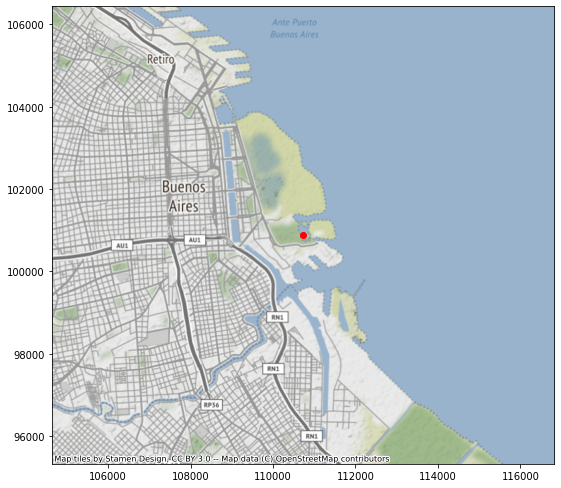

In [19]:
# Pertenece al radio de la ex ciudad deportiva de Boca
ax =radios_parcelas[radios_parcelas.RADIO_ID.isna()].plot(color="red", figsize=(9, 9))
cx.add_basemap(ax, crs=radios_parcelas.crs.to_string())

In [20]:
# imputamos el radio  
radios_parcelas.loc[radios_parcelas.RADIO_ID.isna(),'RADIO_ID'] = '4_18_1'

In [21]:
# Obtenemos el total de superficie edificada por radio censale
tabla = radios_parcelas.reindex(columns = ['SUP_EDIF','RADIO_ID']).groupby('RADIO_ID',as_index=False).sum()
tabla.columns = ['RADIO_ID','superficie_edificada_radio']
tabla.head()

,RADIO_ID,superficie_edificada_radio
0,10_10_1,35789.0
1,10_10_10,35109.0
2,10_10_11,39753.0
3,10_10_12,47011.0
4,10_10_2,50993.0


In [22]:
# Movemos esa información al data frame que contiene las parcelas con la informacion de cada radio 
radios_parcelas = radios_parcelas.merge(tabla, on = 'RADIO_ID',how = 'left')

# Calculamos un ponderador como cuanto contribuye cada parcela a la superficie edificada total del radio 
radios_parcelas['peso'] = radios_parcelas.SUP_EDIF / radios_parcelas.superficie_edificada_radio



In [23]:
radios_parcelas.sample(5)

,index_left,RADIO_ID,POBLACION,SMP,SUP_EDIF,geometry,superficie_edificada_radio,peso
7888,2535.0,5_17_4,842.0,036-027A-003,457.0,POINT (103409.834 101219.609),34025.0,0.013431
28394,2798.0,6_20_6,824.0,040-085-013,521.0,POINT (102626.302 100846.346),60363.0,0.008631
134217,1749.0,15_8_8,931.0,059-098-018,374.0,POINT (99832.070 103278.156),41850.0,0.008937
42022,899.0,12_7_1,836.0,041-021-004,612.0,POINT (98594.252 108027.385),42119.0,0.014530
71463,3402.0,9_4_1,926.0,072-004-025,282.0,POINT (94119.584 97383.013),48548.0,0.005809


In [24]:
# chequeamos que todos los ponderadores sumen 1 para cada radio
radios_parcelas.groupby('RADIO_ID').sum()['peso'].describe()

count    3363.000000
mean        0.997919
std         0.045582
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: peso, dtype: float64

In [25]:
# los radios donde el peso no suma 1 es porque no hay parcelas residenciales con superficie edificada y suma 0

peso_por_radio = radios_parcelas.groupby('RADIO_ID').sum()['peso']
filtro = ((1 - peso_por_radio) > 0.005)
peso_por_radio.loc[filtro.index[filtro.values]].describe()

count    7.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: peso, dtype: float64

In [26]:
#vemos que parcelas son, y aunque pertenecen a radios con poblacion, no se identifica una parcela particular con superficie edificada
radios_parcelas.loc[radios_parcelas.RADIO_ID.isin(filtro.index[filtro.values])].sort_values('RADIO_ID')

,index_left,RADIO_ID,POBLACION,SMP,SUP_EDIF,geometry,superficie_edificada_radio,peso
19372,2311.0,4_17_9,757.0,006-122-001,0.0,POINT (109444.006 100126.983),0.0,NaN
236020,2237.0,4_26_3,1219.0,034-103C-002,0.0,POINT (105407.767 97732.028),0.0,NaN
49842,2981.0,7_17_5,891.0,044-003S-000,0.0,POINT (101781.532 97977.280),0.0,NaN
244802,3334.0,8_17_2,620.0,064-099D-001,0.0,POINT (99285.402 96206.345),0.0,NaN
244803,3334.0,8_17_2,620.0,064-099D-006,0.0,POINT (99308.828 96246.828),0.0,NaN
244541,3333.0,8_17_3,666.0,064-099F-004,0.0,POINT (99412.441 96358.439),0.0,NaN
244542,3342.0,8_17_4,780.0,064-099H-001,0.0,POINT (99478.320 96498.927),0.0,NaN
244543,3342.0,8_17_4,780.0,064-099I-001,0.0,POINT (99507.928 96599.441),0.0,NaN
246081,3342.0,8_17_4,780.0,064-099G-001,0.0,POINT (99534.582 96484.813),0.0,NaN
247800,3138.0,8_1_4,1894.0,078-075I-002,0.0,POINT (97255.645 95358.234),0.0,NaN


In [27]:
# Distribuimos la poblacion con arreglo al peso 
radios_parcelas['poblacion_parcela'] = radios_parcelas.POBLACION * radios_parcelas.peso

In [28]:
# Perdemos cerca del 6% de la poblacion por ambos problemas (radios sin parcelas residenciales o sin euperficie edificada)
(radios.POBLACION.sum() - radios_parcelas.poblacion_parcela.sum()) / radios.POBLACION.sum() * 100

6.129714329804929

In [29]:
tabla_chequeo = radios_parcelas.reindex(columns = ['RADIO_ID','poblacion_parcela']).groupby('RADIO_ID').sum().join(radios.drop('geometry',axis=1).set_index('RADIO_ID'))
tabla_chequeo['diff'] = (tabla_chequeo.POBLACION - tabla_chequeo.poblacion_parcela).round()
tabla_chequeo = tabla_chequeo.sort_values('diff',ascending= False)

In [30]:
tabla_chequeo.head(10)

,poblacion_parcela,POBLACION,diff
RADIO_ID,,,
8_1_4,0.0,1894.0,1894.0
4_26_3,0.0,1219.0,1219.0
7_17_5,0.0,891.0,891.0
8_17_4,0.0,780.0,780.0
4_17_9,0.0,757.0,757.0
8_17_3,0.0,666.0,666.0
8_17_2,0.0,620.0,620.0
4_18_1,0.0,74.0,74.0
4_1_10,491.0,491.0,0.0


In [31]:
radios_parcelas = radios_parcelas.to_crs(epsg=4326)
radios_parcelas.to_file('dasimetrizacion_caba.geojson',driver='GeoJSON')


In [32]:
radios_parcelas = radios_parcelas.to_crs(epsg=3857)


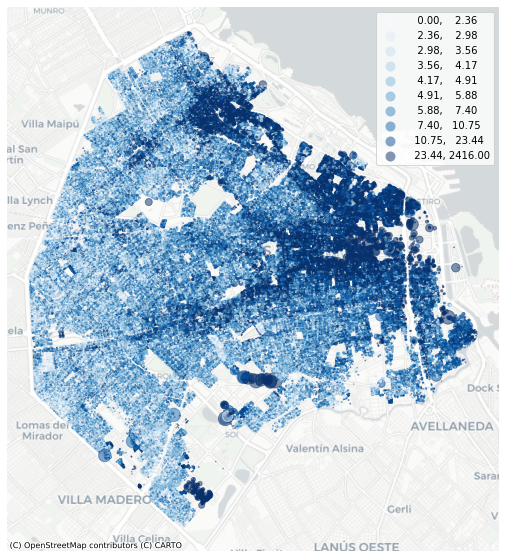

In [33]:
f,ax = plt.subplots(figsize = (10,10))
radios_parcelas.plot(ax=ax,
                     markersize = radios_parcelas.poblacion_parcela / 10,
                     column = 'poblacion_parcela',
                     scheme = 'Quantiles',
                     k = 10,
                     cmap = 'Blues',
                     alpha = 0.5,
                     legend = True
                                  )
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off();

In [34]:
f.savefig('mapa.png')